Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/15


225/225 [==============================] - ETA: 0s - loss: 1.9041 - accuracy: 0.2255
Epoch 1: val_accuracy improved from -inf to 0.24575, saving model to best_xception_model.keras
225/225 [==============================] - 311s 1s/step - loss: 1.9041 - accuracy: 0.2255 - val_loss: 1.8823 - val_accuracy: 0.2458 - lr: 0.0010
Epoch 2/15
225/225 [==============================] - ETA: 0s - loss: 1.8274 - accuracy: 0.2525
Epoch 2: val_accuracy improved from 0.24575 to 0.24909, saving model to best_xception_model.keras
225/225 [==============================] - 325s 1s/step - loss: 1.8274 - accuracy: 0.2525 - val_loss: 1.7861 - val_accuracy: 0.2491 - lr: 0.0010
Epoch 3/15
225/225 [==============================] - ETA: 0s - loss: 1.7737 - accuracy: 0.2557
Epoch 3: val_accuracy improved from 0.24909 to 0.26191, saving model to best_xception_model.keras
225/225 [==============================] - 3

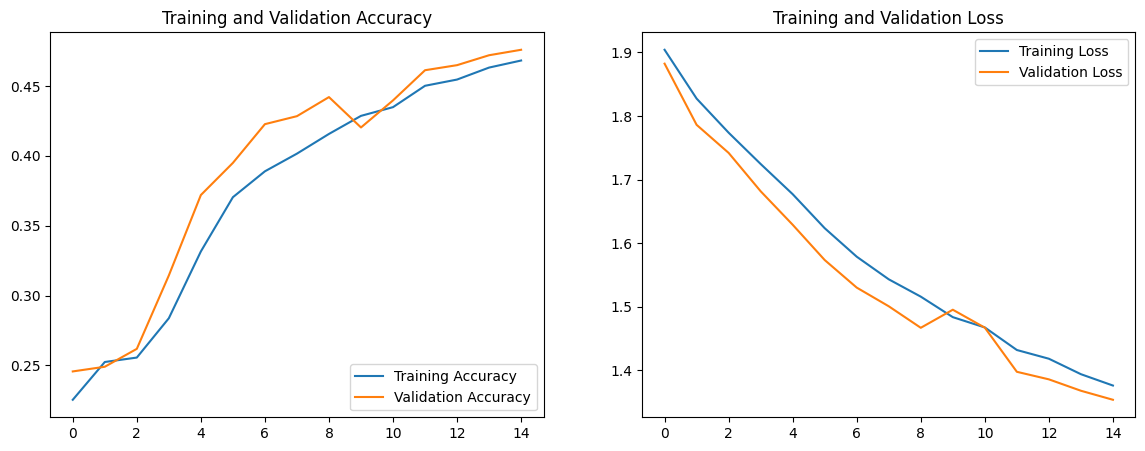

Test Loss: 1.3537, Test Accuracy: 0.4759
Classification Report:
              precision    recall  f1-score   support

       angry       0.35      0.04      0.08       958
     disgust       0.00      0.00      0.00       111
        fear       0.28      0.13      0.18      1024
       happy       0.71      0.74      0.72      1774
     neutral       0.36      0.65      0.46      1233
         sad       0.36      0.46      0.40      1247
    surprise       0.61      0.68      0.64       831

    accuracy                           0.48      7178
   macro avg       0.38      0.39      0.36      7178
weighted avg       0.46      0.48      0.44      7178



d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

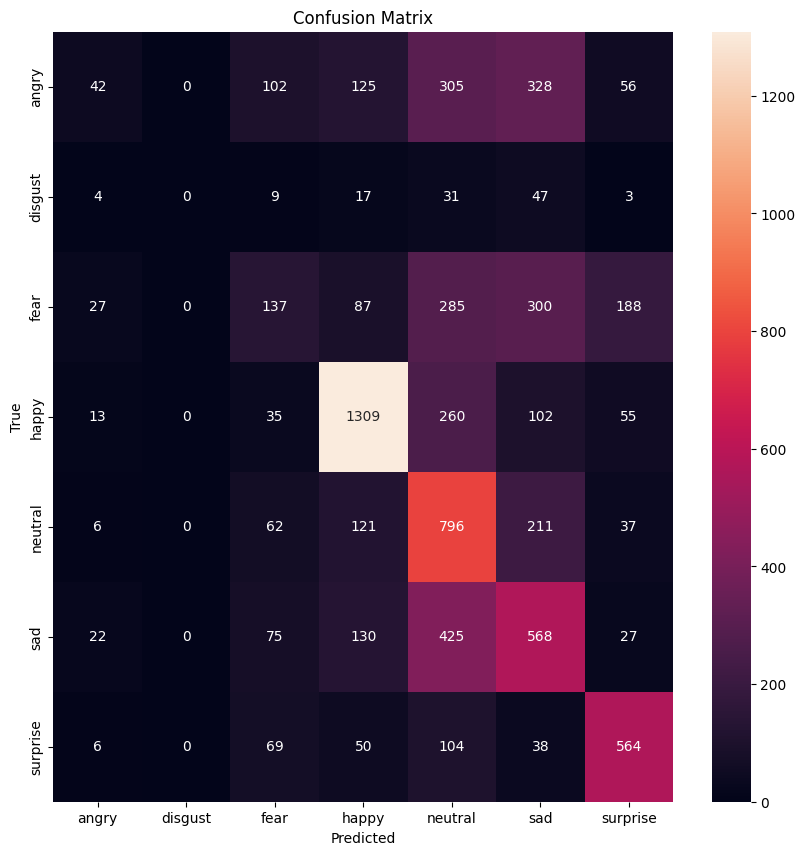

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, Input, Conv2D, BatchNormalization,
    Activation, Add, Multiply, Flatten
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Define constants and hyperparameters
CONFIG = {
    'INPUT_IMAGE_SIZE': (75, 75),
    'TRAIN_BATCH_SIZE': 128,
    'TEST_BATCH_SIZE': 128,
    'EPOCHS': 15,
    'LEARNING_RATE': 0.001,
    'MOMENTUM': 0.8,
    'NUM_CLASSES': 7,
}

# Define the transfer learning model using Xception with added attention mechanism
def create_transfer_model(input_shape, num_classes):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Fine-tune the entire model

    # Ensure the attention layer has the same number of filters as the base model output
    num_filters = base_model.output.shape[-1]

    # Add attention mechanism
    attention_layer = Conv2D(num_filters, kernel_size=(1, 1), padding='same')(base_model.output)
    attention_layer = BatchNormalization()(attention_layer)
    attention_layer = Activation('sigmoid')(attention_layer)
    attention_layer = Multiply()([base_model.output, attention_layer])

    x = GlobalAveragePooling2D()(attention_layer)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    # Use SGD optimizer with momentum
    optimizer = SGD(learning_rate=CONFIG['LEARNING_RATE'], momentum=CONFIG['MOMENTUM'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Load and preprocess the data
def load_data(train_dir, test_dir, img_size, train_batch_size, test_batch_size):
    # Increased data augmentation for the training set
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        color_mode='rgb',
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True
    )

    test_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        color_mode='rgb',
        batch_size=test_batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_data, test_data

# Define callbacks
def create_callbacks():
    log_dir = "logs/fit/xception_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
        ModelCheckpoint('best_xception_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
    return callbacks

# Function to train and evaluate the model
def train_and_evaluate_model(model, train_data, test_data, epochs, callbacks):
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=test_data,
        callbacks=callbacks,
        verbose=1
    )
    return history

# Function to plot training and validation metrics
def plot_metrics(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(accuracy))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Function to evaluate the model and display classification metrics
def evaluate_model(model, test_data):
    test_loss, test_accuracy = model.evaluate(test_data, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    predictions = model.predict(test_data, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_data.classes
    class_labels = list(test_data.class_indices.keys())

    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Main script
def main():
    train_dir = 'data/train'
    test_dir = 'data/test'

    train_data, test_data = load_data(
        train_dir,
        test_dir,
        img_size=CONFIG['INPUT_IMAGE_SIZE'],
        train_batch_size=CONFIG['TRAIN_BATCH_SIZE'],
        test_batch_size=CONFIG['TEST_BATCH_SIZE']
    )
    

    model = create_transfer_model(input_shape=(*CONFIG['INPUT_IMAGE_SIZE'], 3), num_classes=CONFIG['NUM_CLASSES'])
    callbacks = create_callbacks()
    history = train_and_evaluate_model(model, train_data, test_data, CONFIG['EPOCHS'], callbacks)
    plot_metrics(history)
    evaluate_model(model, test_data)
    model.save('xception_model.h5')

if __name__ == '__main__':
    main()

In [2]:
# opening webcam and detecting emotions in real time using the trained model
import cv2
from tensorflow.keras.models import load_model
import numpy as np

# Load the trained model
model = load_model('best_xception_model.keras')

# Define the emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Open the webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the image to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Crop the face
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (75, 75, 3))
        face = np.expand_dims(face, axis=0)
        face = np.expand_dims(face, axis=3)

        # Predict the emotion
        prediction = model.predict(face)
        predicted_class = np.argmax(prediction)
        label = emotion_labels[predicted_class]

        # Display the emotion
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, label, (x, y-10), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Emotion Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


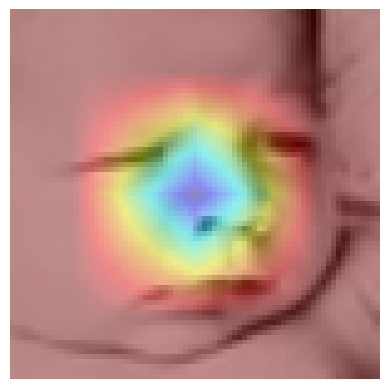

Found 7178 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
4/4 [==============================] - 0s 115ms/step


AbortedError: Graph execution error:

Detected at node model_2/block14_sepconv1_act/Relu defined at (most recent call last):
  File "C:\Users\moham\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\moham\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\moham\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever

  File "C:\Users\moham\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once

  File "C:\Users\moham\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\moham\AppData\Local\Temp\ipykernel_11084\2334758191.py", line 81, in <module>

  File "C:\Users\moham\AppData\Local\Temp\ipykernel_11084\2334758191.py", line 39, in analyze_misclassifications

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\training.py", line 2655, in predict

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\layers\core\activation.py", line 59, in call

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\activations.py", line 306, in relu

  File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\backend.py", line 5395, in relu

Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:1093
	 [[{{node model_2/block14_sepconv1_act/Relu}}]] [Op:__inference_predict_function_575254]

In [7]:
# Grad-CAM visualization
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import preprocess_input

def generate_grad_cam(model, image_path, layer_name='block14_sepconv2_act'):
    img = cv2.imread(image_path)
    img = cv2.resize(img, CONFIG['INPUT_IMAGE_SIZE'])
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    heatmap = cv2.resize(heatmap[0], CONFIG['INPUT_IMAGE_SIZE'])
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    img = cv2.imread(image_path)
    img = cv2.resize(img, CONFIG['INPUT_IMAGE_SIZE'])
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return superimposed_img

# Error analysis
def analyze_misclassifications(model, test_data):
    misclassified_samples = []
    true_labels = []
    predicted_labels = []

    for images, labels in test_data:
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)

        misclassified_mask = predicted_classes != true_classes
        misclassified_samples.extend(images[misclassified_mask])
        true_labels.extend(true_classes[misclassified_mask])
        predicted_labels.extend(predicted_classes[misclassified_mask])

    misclassified_samples = np.array(misclassified_samples)
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    return misclassified_samples, true_labels, predicted_labels

def display_misclassifications(misclassified_samples, true_labels, predicted_labels, class_labels):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(misclassified_samples[i])
        ax.set_title(f"True: {class_labels[true_labels[i]]}, Predicted: {class_labels[predicted_labels[i]]}")
        ax.axis('off')
    plt.show()

# Load the best model and visualize Grad-CAM
best_model = tf.keras.models.load_model('best_xception_model.keras')
image_path = 'data/test/angry/PrivateTest_88305.jpg'
grad_cam_img = generate_grad_cam(best_model, image_path)
plt.imshow(grad_cam_img)
plt.axis('off')
plt.show()


test_data = load_data(
    'data/test',
    img_size=CONFIG['INPUT_IMAGE_SIZE'],
    train_batch_size=CONFIG['TEST_BATCH_SIZE'],
    test_batch_size=CONFIG['TEST_BATCH_SIZE'],
    test_dir='data/test'
)[1]

# Analyze misclassifications
class_labels = list(test_data.class_indices.keys())
misclassified_samples, true_labels, predicted_labels = analyze_misclassifications(best_model, test_data)
display_misclassifications(misclassified_samples, true_labels, predicted_labels, class_labels)